##############################################################
# BG-NBD ve Gamma-Gamma ile CLTV Prediction
##############################################################


In [1]:
# import libraries
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter
from lifetimes.plotting import plot_period_transactions
from sklearn.preprocessing import MinMaxScaler

In [2]:
#aykırı değerleri törpüleyen fonksiyon 
def outlier_thresholds(dataframe, variable):
    quartile1 = dataframe[variable].quantile(0.01)
    quartile3 = dataframe[variable].quantile(0.99)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

In [3]:
def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    # dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

In [4]:
df_ = pd.read_excel(r'C:\Users\LENOVO\PycharmProjects\DSMLBC4\datasets\online_retail_II.xlsx',
                    sheet_name="Year 2010-2011")
df = df_.copy()
df.shape

(541910, 8)

In [5]:
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541910 entries, 0 to 541909
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      541910 non-null  object        
 1   StockCode    541910 non-null  object        
 2   Description  540456 non-null  object        
 3   Quantity     541910 non-null  int64         
 4   InvoiceDate  541910 non-null  datetime64[ns]
 5   Price        541910 non-null  float64       
 6   Customer ID  406830 non-null  float64       
 7   Country      541910 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [7]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,541910.0,9.552234,218.080957,-80995.00,1.00,3.00,10.00,80995.0
Price,541910.0,4.611138,96.759765,-11062.06,1.25,2.08,4.13,38970.0
Customer ID,406830.0,15287.684160,1713.603074,12346.00,13953.00,15152.00,16791.00,18287.0


In [8]:
df.dropna(inplace=True)
df = df[~df["Invoice"].str.contains("C", na=False)]
df = df[df["Quantity"] > 0]

In [9]:
#UK müşterilerinin seçilmesi.
df = df[df["Country"].str.contains("United Kingdom")]
df["Country"].head()

0    United Kingdom
1    United Kingdom
2    United Kingdom
3    United Kingdom
4    United Kingdom
Name: Country, dtype: object

In [10]:
replace_with_thresholds(df, "Quantity")
replace_with_thresholds(df, "Price")

In [11]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,354345.0,10.676869,22.075531,1.0,2.00,4.00,12.00,248.50
Price,354345.0,2.815039,2.920551,0.0,1.25,1.95,3.75,31.56
Customer ID,354345.0,15552.436219,1594.546025,12346.0,14194.00,15522.00,16931.00,18287.00


In [12]:
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6.0,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6.0,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8.0,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6.0,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6.0,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [13]:
df["TotalPrice"] = df["Quantity"] * df["Price"]

In [15]:
df["InvoiceDate"].max()
today_date = dt.datetime(2011, 12, 11)

#############################################
# RFM Table
#############################################

In [16]:
# Recency kullanıcıya özel dinamik.
rfm = df.groupby('Customer ID').agg({'InvoiceDate': [lambda date: (date.max() - date.min()).days,
                                                     lambda date: (today_date - date.min()).days],#Tenure
                                     'Invoice': lambda num: num.nunique(),
                                     'TotalPrice': lambda TotalPrice: TotalPrice.sum()})

rfm.columns = rfm.columns.droplevel(0)
rfm.head()

,<lambda_0>,<lambda_1>,<lambda>,<lambda>
Customer ID,,,,
12346.0,0,326,1,258.44
12747.0,366,370,11,4196.01
12748.0,372,374,210,32303.91
12749.0,209,214,5,4072.44
12820.0,323,327,4,942.34


In [17]:
## recency_cltv_p
rfm.columns = ['recency_cltv_p', 'T', 'frequency', 'monetary']

In [18]:
## basitleştirilmiş monetary_avg
rfm["monetary"] = rfm["monetary"] / rfm["frequency"]
rfm.rename(columns={"monetary": "monetary_avg"}, inplace=True)

## BGNBD için WEEKLY RECENCY VE WEEKLY T'nin HESAPLANMASI

In [19]:
## recency_weekly_p
rfm["recency_weekly_p"] = rfm["recency_cltv_p"] / 7
rfm["T_weekly"] = rfm["T"] / 7
rfm.head()

,recency_cltv_p,T,frequency,monetary_avg,recency_weekly_p,T_weekly
Customer ID,,,,,,
12346.0,0,326,1,258.440000,0.000000,46.571429
12747.0,366,370,11,381.455455,52.285714,52.857143
12748.0,372,374,210,153.828143,53.142857,53.428571
12749.0,209,214,5,814.488000,29.857143,30.571429
12820.0,323,327,4,235.585000,46.142857,46.714286


In [20]:
# KONTROL
rfm = rfm[rfm["monetary_avg"] > 0]

In [21]:
## freq > 1
rfm = rfm[(rfm['frequency'] > 1)]
rfm["frequency"] = rfm["frequency"].astype(int)

In [22]:
# Beklenen satışların tahmini bu modelle yapılır.
# pip install lifetimes

bgf = BetaGeoFitter(penalizer_coef=0.001)

bgf.fit(rfm['frequency'],
        rfm['recency_weekly_p'],
        rfm['T_weekly'])

<lifetimes.BetaGeoFitter: fitted with 2570 subjects, a: 0.12, alpha: 11.66, b: 2.51, r: 2.21>

In [23]:
################################################################
# 1 hafta içinde en çok satın alma beklediğimiz 10 müşteri kimdir?
################################################################

bgf.conditional_expected_number_of_purchases_up_to_time(1,
                                                        rfm['frequency'],
                                                        rfm['recency_weekly_p'],
                                                        rfm['T_weekly']).sort_values(ascending=False).head(10)


Customer ID
12748.0    3.252952
17841.0    1.933252
13089.0    1.532019
14606.0    1.458797
15311.0    1.428625
12971.0    1.352266
13408.0    0.982914
18102.0    0.965291
13798.0    0.908239
14527.0    0.882959
dtype: float64

In [24]:
#expected number of purchases= beklenen satın alma sayısı
rfm["expected_number_of_purchases"] = bgf.predict(1,
                                                  rfm['frequency'],
                                                  rfm['recency_weekly_p'],
                                                  rfm['T_weekly'])

rfm.head()

,recency_cltv_p,T,frequency,monetary_avg,recency_weekly_p,T_weekly,expected_number_of_purchases
Customer ID,,,,,,,
12747.0,366,370,11,381.455455,52.285714,52.857143,0.202479
12748.0,372,374,210,153.828143,53.142857,53.428571,3.252952
12749.0,209,214,5,814.488000,29.857143,30.571429,0.167149
12820.0,323,327,4,235.585000,46.142857,46.714286,0.103972
12822.0,16,88,2,474.440000,2.285714,12.571429,0.129141


In [25]:
################################################################
# 1 ay içinde en çok satın alma beklediğimiz 10 müşteri kimdir?
################################################################


bgf.predict(4,#hafta sayısını gösterir
            rfm['frequency'],
            rfm['recency_weekly_p'],
            rfm['T_weekly']).sort_values(ascending=False).head(10)

rfm["expected_number_of_purchases"] = bgf.predict(4,
                                                  rfm['frequency'],
                                                  rfm['recency_weekly_p'],
                                                  rfm['T_weekly'])

rfm.sort_values("expected_number_of_purchases", ascending=False).head(20)

,recency_cltv_p,T,frequency,monetary_avg,recency_weekly_p,T_weekly,expected_number_of_purchases
Customer ID,,,,,,,
12748.0,372,374,210,153.828143,53.142857,53.428571,12.977515
17841.0,371,374,124,328.822339,53.000000,53.428571,7.712588
13089.0,366,370,97,605.186598,52.285714,52.857143,6.111736
14606.0,372,374,93,129.961613,53.142857,53.428571,5.819756
15311.0,373,374,91,667.596813,53.285714,53.428571,5.699386
12971.0,368,373,86,127.049826,52.571429,53.285714,5.394723
13408.0,371,374,62,453.281935,53.000000,53.428571,3.921229
18102.0,366,368,60,3584.887750,52.285714,52.571429,3.850788
13798.0,370,373,57,650.511140,52.857143,53.285714,3.623295


In [26]:
################################################################
# 1 Ay içinde tüm Şirketin Beklenen Satış Sayısı Nedir?
################################################################

bgf.predict(4,
            rfm['frequency'],
            rfm['recency_weekly_p'],
            rfm['T_weekly']).sum()

1597.273267103235

In [27]:
################################################################
# 3 Ayda Tüm Şirketin Beklenen Satış Sayısı Nedir?
################################################################


bgf.predict(4 * 3,
            rfm['frequency'],
            rfm['recency_weekly_p'],
            rfm['T_weekly']).sum()

4738.999309834784

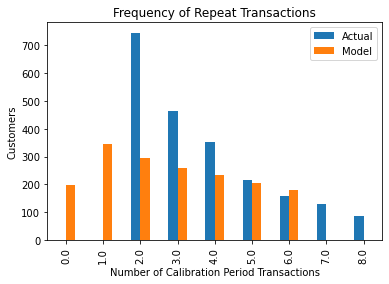

In [28]:
################################################################
# Tahmin Sonuçlarının Değerlendirilmesi
################################################################

plot_period_transactions(bgf)
plt.show()

In [29]:
##############################################################
# 3. GAMMA-GAMMA Modelinin Kurulması
#beklenen karlılığın hesaplanması
##############################################################


ggf = GammaGammaFitter(penalizer_coef=0.01)
ggf.fit(rfm['frequency'], rfm['monetary_avg'])

#En değerli 10 müşteri
ggf.conditional_expected_average_profit(rfm['frequency'],
                                        rfm['monetary_avg']).head(10)
#sıralarsak;
ggf.conditional_expected_average_profit(rfm['frequency'],
                                        rfm['monetary_avg']).sort_values(ascending=False).head(10)

rfm["expected_average_profit"] = ggf.conditional_expected_average_profit(rfm['frequency'],
                                                                         rfm['monetary_avg'])

rfm.sort_values("expected_average_profit", ascending=False).head(20)

,recency_cltv_p,T,frequency,monetary_avg,recency_weekly_p,T_weekly,expected_number_of_purchases,expected_average_profit
Customer ID,,,,,,,,
14088.0,312,323,13,3859.601538,44.571429,46.142857,1.035750,3911.318850
18102.0,366,368,60,3584.887750,52.285714,52.571429,3.850788,3595.192557
14096.0,97,102,17,3159.077059,13.857143,14.571429,2.873545,3191.386734
17511.0,370,374,31,2921.951935,52.857143,53.428571,2.024069,2938.274487
15749.0,97,333,3,2521.446667,13.857143,47.571429,0.113163,2675.118999
17450.0,359,368,46,2629.529891,51.285714,52.571429,2.972272,2639.419342
13081.0,359,372,11,2575.622727,51.285714,53.142857,0.801576,2616.624391
16984.0,41,131,2,2240.675000,5.857143,18.714286,0.410693,2452.124911
16000.0,0,3,3,2055.786667,0.000000,0.428571,1.640945,2181.323596


##############################################################
# 4. BG-NBD ve GG modeli ile CLTV'nin hesaplanması.
##############################################################

In [30]:
cltv = ggf.customer_lifetime_value(bgf,
                                   rfm['frequency'],
                                   rfm['recency_weekly_p'],
                                   rfm['T_weekly'],
                                   rfm['monetary_avg'],
                                   time=6,  # 6 aylık
                                   freq="W",  # T'nin frekans bilgisi.
                                   discount_rate=0.01)

cltv.head()

Customer ID
12747.0     1937.046140
12748.0    12365.796180
12749.0     3446.010436
12820.0      631.939332
12822.0     1612.096652
Name: clv, dtype: float64

In [31]:
cltv.shape

(2570,)

In [32]:
cltv = cltv.reset_index()
cltv.sort_values(by="clv", ascending=False).head()

,Customer ID,clv
2486,18102.0,85651.010467
589,14096.0,55650.646773
2184,17450.0,48533.310108
2213,17511.0,36797.006732
1804,16684.0,25083.025410


In [33]:
rfm_cltv_final = rfm.merge(cltv, on="Customer ID", how="left")
rfm_cltv_final.head()

,Customer ID,recency_cltv_p,T,frequency,monetary_avg,recency_weekly_p,T_weekly,expected_number_of_purchases,expected_average_profit,clv
0,12747.0,366,370,11,381.455455,52.285714,52.857143,0.807679,387.822846,1937.046140
1,12748.0,372,374,210,153.828143,53.142857,53.428571,12.977515,153.971325,12365.796180
2,12749.0,209,214,5,814.488000,29.857143,30.571429,0.665729,844.094697,3446.010436
3,12820.0,323,327,4,235.585000,46.142857,46.714286,0.414566,247.080949,631.939332
4,12822.0,16,88,2,474.440000,2.285714,12.571429,0.512653,520.828195,1612.096652


In [34]:
rfm_cltv_final.sort_values(by="clv", ascending=False).head(20)

,Customer ID,recency_cltv_p,T,frequency,monetary_avg,recency_weekly_p,T_weekly,expected_number_of_purchases,expected_average_profit,clv
2486,18102.0,366,368,60,3584.887750,52.285714,52.571429,3.850788,3595.192557,85651.010467
589,14096.0,97,102,17,3159.077059,13.857143,14.571429,2.873545,3191.386734,55650.646773
2184,17450.0,359,368,46,2629.529891,51.285714,52.571429,2.972272,2639.419342,48533.310108
2213,17511.0,370,374,31,2921.951935,52.857143,53.428571,2.024069,2938.274487,36797.006732
1804,16684.0,353,359,28,2120.046964,50.428571,51.285714,1.901458,2133.203588,25083.025410
406,13694.0,369,374,50,1267.362600,52.714286,53.428571,3.184517,1271.785404,25060.708710
587,14088.0,312,323,13,3859.601538,44.571429,46.142857,1.035750,3911.318850,25010.059127
1173,15311.0,373,374,91,667.596813,53.285714,53.428571,5.699386,668.894460,23591.389482
133,13089.0,366,370,97,605.186598,52.285714,52.857143,6.111736,606.293663,22927.692955
1057,15061.0,368,373,48,1108.307812,52.571429,53.285714,3.069009,1112.347121,21123.082064


In [35]:
#2010-2011 UK müşterileri için 1 aylık ve 12 aylık CLTV hesabı.
cltv = ggf.customer_lifetime_value(bgf,
                                   rfm['frequency'],
                                   rfm['recency_weekly_p'],
                                   rfm['T_weekly'],
                                   rfm['monetary_avg'],
                                   time=1,  # 1 aylık
                                   freq="W",  # T'nin frekans bilgisi.
                                   discount_rate=0.01)

cltv.head()

Customer ID
12747.0     336.778826
12748.0    2148.375671
12749.0     604.071001
12820.0     110.124851
12822.0     286.922336
Name: clv, dtype: float64

In [36]:
cltv = cltv.reset_index()
cltv.sort_values(by="clv", ascending=False).head(12)

,Customer ID,clv
2486,18102.0,14884.974999
589,14096.0,9855.879890
2184,17450.0,8434.764722
2213,17511.0,6394.324321
1804,16684.0,4361.053957
587,14088.0,4355.485259
406,13694.0,4354.468531
1173,15311.0,4098.869447
133,13089.0,3984.051505
1485,16000.0,3843.979499


In [37]:
rfm_cltv_final = rfm.merge(cltv, on="Customer ID", how="left")
rfm_cltv_final.head()

,Customer ID,recency_cltv_p,T,frequency,monetary_avg,recency_weekly_p,T_weekly,expected_number_of_purchases,expected_average_profit,clv
0,12747.0,366,370,11,381.455455,52.285714,52.857143,0.807679,387.822846,336.778826
1,12748.0,372,374,210,153.828143,53.142857,53.428571,12.977515,153.971325,2148.375671
2,12749.0,209,214,5,814.488000,29.857143,30.571429,0.665729,844.094697,604.071001
3,12820.0,323,327,4,235.585000,46.142857,46.714286,0.414566,247.080949,110.124851
4,12822.0,16,88,2,474.440000,2.285714,12.571429,0.512653,520.828195,286.922336


In [38]:
cltv = ggf.customer_lifetime_value(bgf,
                                   rfm['frequency'],
                                   rfm['recency_weekly_p'],
                                   rfm['T_weekly'],
                                   rfm['monetary_avg'],
                                   time=12,  # 12 aylık
                                   freq="W",  # T'nin frekans bilgisi.
                                   discount_rate=0.01)

cltv.head()

Customer ID
12747.0     3698.381136
12748.0    23623.996889
12749.0     6538.827675
12820.0     1204.326224
12822.0     3029.794538
Name: clv, dtype: float64

In [39]:
cltv.shape

(2570,)

In [40]:
cltv = cltv.reset_index()
cltv.sort_values(by="clv", ascending=False).head(12)

,Customer ID,clv
2486,18102.0,163591.126764
589,14096.0,104900.442916
2184,17450.0,92694.274819
2213,17511.0,70285.652300
1804,16684.0,47890.364207
406,13694.0,47871.899999
587,14088.0,47688.863650
1173,15311.0,45067.809393
133,13089.0,43795.472864
1057,15061.0,40348.816688


In [41]:
rfm_cltv_final = rfm.merge(cltv, on="Customer ID", how="left")
rfm_cltv_final.head()

,Customer ID,recency_cltv_p,T,frequency,monetary_avg,recency_weekly_p,T_weekly,expected_number_of_purchases,expected_average_profit,clv
0,12747.0,366,370,11,381.455455,52.285714,52.857143,0.807679,387.822846,3698.381136
1,12748.0,372,374,210,153.828143,53.142857,53.428571,12.977515,153.971325,23623.996889
2,12749.0,209,214,5,814.488000,29.857143,30.571429,0.665729,844.094697,6538.827675
3,12820.0,323,327,4,235.585000,46.142857,46.714286,0.414566,247.080949,1204.326224
4,12822.0,16,88,2,474.440000,2.285714,12.571429,0.512653,520.828195,3029.794538


In [42]:
#2010-2011 UK müşterileri için 6 aylık CLTV'ye göre tüm müşterilerin 3 segmente ayrılması.

In [43]:
cltv = ggf.customer_lifetime_value(bgf,
                                   rfm['frequency'],
                                   rfm['recency_weekly_p'],
                                   rfm['T_weekly'],
                                   rfm['monetary_avg'],
                                   time=6,  # 6 aylık
                                   freq="W",  # T'nin frekans bilgisi.
                                   discount_rate=0.01)

cltv.head()

Customer ID
12747.0     1937.046140
12748.0    12365.796180
12749.0     3446.010436
12820.0      631.939332
12822.0     1612.096652
Name: clv, dtype: float64

In [44]:
cltv.shape[0]

2570

In [45]:
cltv = cltv.reset_index()
cltv.sort_values(by="clv", ascending=False).head()

,Customer ID,clv
2486,18102.0,85651.010467
589,14096.0,55650.646773
2184,17450.0,48533.310108
2213,17511.0,36797.006732
1804,16684.0,25083.025410


In [46]:
rfm_cltv_final = rfm.merge(cltv, on="Customer ID", how="left")
rfm_cltv_final.head()

,Customer ID,recency_cltv_p,T,frequency,monetary_avg,recency_weekly_p,T_weekly,expected_number_of_purchases,expected_average_profit,clv
0,12747.0,366,370,11,381.455455,52.285714,52.857143,0.807679,387.822846,1937.046140
1,12748.0,372,374,210,153.828143,53.142857,53.428571,12.977515,153.971325,12365.796180
2,12749.0,209,214,5,814.488000,29.857143,30.571429,0.665729,844.094697,3446.010436
3,12820.0,323,327,4,235.585000,46.142857,46.714286,0.414566,247.080949,631.939332
4,12822.0,16,88,2,474.440000,2.285714,12.571429,0.512653,520.828195,1612.096652


In [47]:
rfm_cltv_final["segment"] = pd.qcut(rfm_cltv_final["clv"], 3, labels=["C", "B", "A"])
rfm_cltv_final = rfm_cltv_final.sort_values(by="clv", ascending=False)
rfm_cltv_final=rfm_cltv_final.reset_index()
rfm_cltv_final.head()

,index,Customer ID,recency_cltv_p,T,frequency,monetary_avg,recency_weekly_p,T_weekly,expected_number_of_purchases,expected_average_profit,clv,segment
0,2486,18102.0,366,368,60,3584.887750,52.285714,52.571429,3.850788,3595.192557,85651.010467,A
1,589,14096.0,97,102,17,3159.077059,13.857143,14.571429,2.873545,3191.386734,55650.646773,A
2,2184,17450.0,359,368,46,2629.529891,51.285714,52.571429,2.972272,2639.419342,48533.310108,A
3,2213,17511.0,370,374,31,2921.951935,52.857143,53.428571,2.024069,2938.274487,36797.006732,A
4,1804,16684.0,353,359,28,2120.046964,50.428571,51.285714,1.901458,2133.203588,25083.025410,A


In [48]:
len(rfm_cltv_final)

2570

In [49]:
#CLTV'ye göre en iyi yüzde 20 dilimindekiler

In [50]:
(rfm_cltv_final.shape[0] *0.20)

514.0

In [51]:
rfm_cltv_final["top_flag"] = 0
rfm_cltv_final["top_flag"].iloc[0:515] = 1

In [52]:
rfm_cltv_final.head()

,index,Customer ID,recency_cltv_p,T,frequency,monetary_avg,recency_weekly_p,T_weekly,expected_number_of_purchases,expected_average_profit,clv,segment,top_flag
0,2486,18102.0,366,368,60,3584.887750,52.285714,52.571429,3.850788,3595.192557,85651.010467,A,1
1,589,14096.0,97,102,17,3159.077059,13.857143,14.571429,2.873545,3191.386734,55650.646773,A,1
2,2184,17450.0,359,368,46,2629.529891,51.285714,52.571429,2.972272,2639.419342,48533.310108,A,1
3,2213,17511.0,370,374,31,2921.951935,52.857143,53.428571,2.024069,2938.274487,36797.006732,A,1
4,1804,16684.0,353,359,28,2120.046964,50.428571,51.285714,1.901458,2133.203588,25083.025410,A,1
